In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [2]:
%config Completer.use_jedi = False

# 1.Loading the dataset

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2.Exploratory data analysis

# 2.1 Check missing values

## Check missing values

In [5]:
def plot_missing_data(dataset,tittle):
    fig,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(dataset.isnull(),cbar = False)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


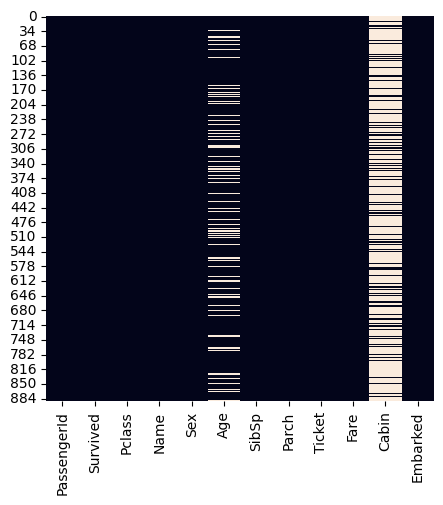

In [7]:
plot_missing_data(train_data, "Training Dataset")

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


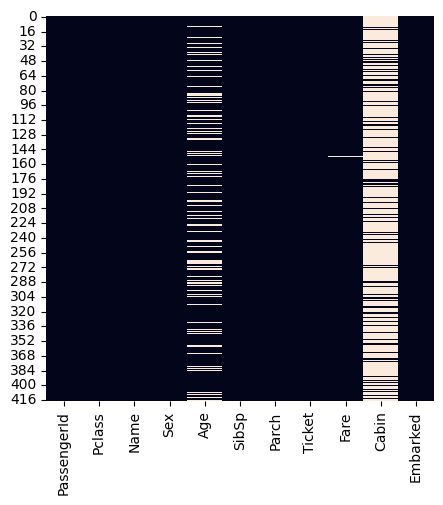

In [9]:
plot_missing_data(test_data, "Test Dataset")

### Obeservtions:

From the blots above we can see that both training as well as test dataset contain features with missing values. However, the most sparse features are Age as well as Cabin.

As we do not know the how much information the features yield, further investigation is needed.

In [10]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))


## 2.2 Analyse Feature Survived

1.Let's try to understand how many people survived overall:

In [11]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [12]:
train_data["Survived"].value_counts(normalize = True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

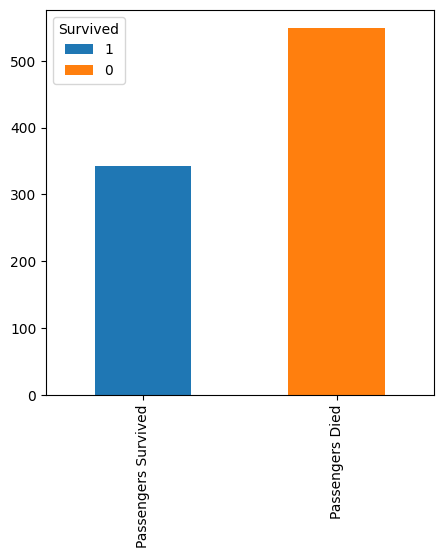

In [13]:
bar_chart_stacked(train_data, "Survived")

### Observations:

As expected the majority of passengers in the training data died. Only 38% survived the disaster. So the training data suffers from data imbalance but it is not severe which is why I will not cosider techniques like sampling to tackle the imbalance.

## 2.3 Analyse Feature Sex

In [14]:
train_data["Sex"].value_counts().to_frame()

,count
Sex,
male,577
female,314


### Observation:
As the majority of passenger were we could infer that the majority of survivors were men.

We can check this assumption by looking at the bar chart below:

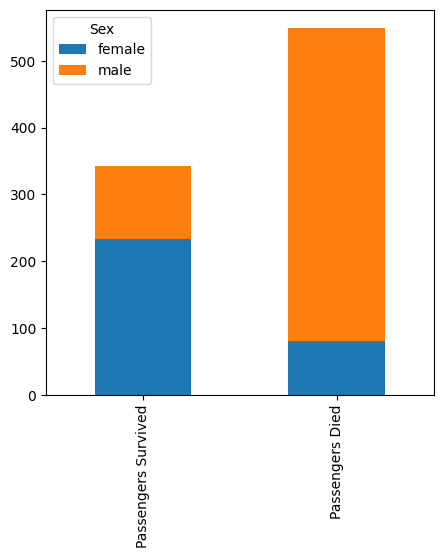

In [15]:
bar_chart_stacked(train_data,"Sex")

In [16]:
women = train_data.loc[train_data.Sex == "female"]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [17]:
men =train_data.loc[train_data.Sex == "male"]["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived: ", rate_men)

% of men who survived:  0.18890814558058924


In [18]:
train_data.groupby("Sex").Survived.mean().to_frame()
                   

,Survived
Sex,
female,0.742038
male,0.188908


### Observations:
Here, we can see the even though the majority of the passenger were male, the majority of survivors were female. The key observation here is that the survival rate for female passengers is 4 times higher than the survival rate of male passengers.

## 2.4 Analyse Feature Pclass:

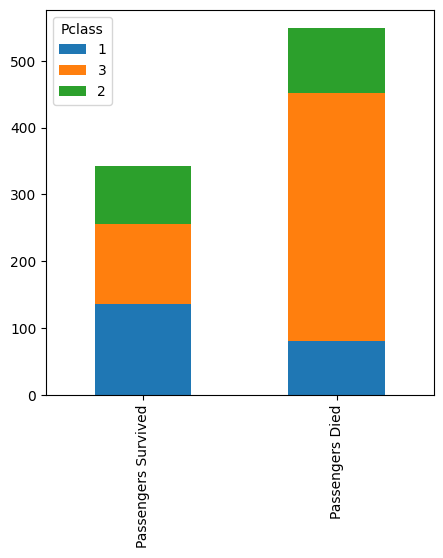

In [19]:
bar_chart_stacked(train_data, "Pclass")

In [20]:
pd.pivot_table(train_data, index = "Survived", columns = "Pclass", values ="Ticket", aggfunc ="count")

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [21]:
train_data.groupby(["Pclass"]).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Observations: 

From the plots and tables above it becomes clear that the Pclass is an important factor to consider.

   -  Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
   - Almost 63% of the passenger from class 1 survived.
   - Also approx 50% of the class 2 passenger survived.

One questions that comes into mind is:

Is the class or sex the deciding factor?

In [22]:
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')


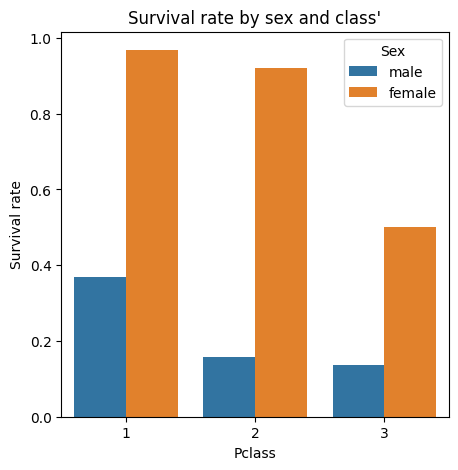

In [23]:
bar_chart_compare(train_data,"Pclass", "Sex")

In [24]:
pd.pivot_table(train_data, index ="Survived", columns = ["Pclass", "Sex"], values= "Ticket", aggfunc = "count" )

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [25]:
train_data.groupby(["Pclass","Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

### Observations;

Here, we can clearly see that the question was justified. Irrespective of the class the most important factor when it comes to surviving was gender. (At least between Sex and Pclass) However, men in class 1 had a significantly higher chance of survival when they bought class 1 tickets. This just shows to say that we should keep both features as both yield insightful information that should help our model.

   - Survival Rate females 1. Class: 96,8%

   - Survival Rate females 2. Class: 92,1%

   - Survival Rate females 3. Class: 50%

   - Survival Rate male 1. Class: 36.8%
     (still significantly lower than 3. class females)


## 2.5 Analyse Feature Age

In [26]:
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.histplot(train_data[feature], color='g', bins=bins, ax=ax)


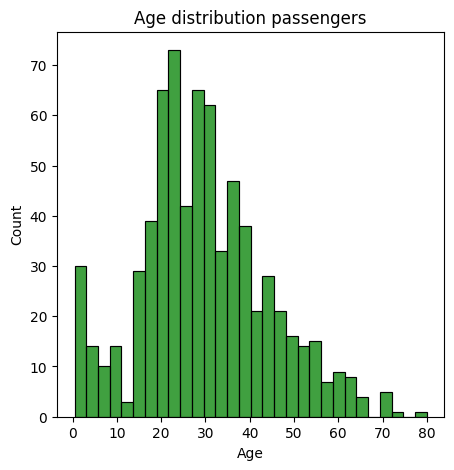

In [27]:
plot_distribution(train_data, "Age" , "Age distribution passengers")

In [28]:
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(dataset[feature1].loc[train_data["Survived"] == 1],
                fill= True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_data["Survived"] == 0],
                fill=True, ax=ax, label="Died")

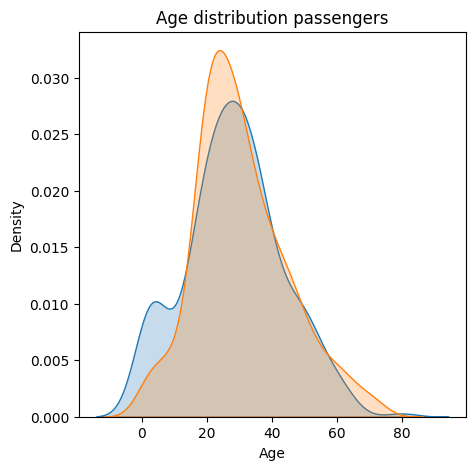

In [29]:
plot_kernel_density_estimate_survivors(train_data, "Age", "Age distribution passengers")

### Observations

The Histogram above shows that age follows a fairly normal distribution.

Also investigating the kernel density estimate does not provide additional information except a raise in survivors at a very young age. However, one idea might be to investigate age and sex together.

## 2.6 Analyze FeatureFeature Age & Sex together:

In [30]:
def plot_swarm_survivors(dataset, feature1, feature2, title, marker_size=5):
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.grid(True)
    plt.xticks(list(range(0, 10, 2)))
    
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=dataset, s=marker_size)
    ax.set_title(title)


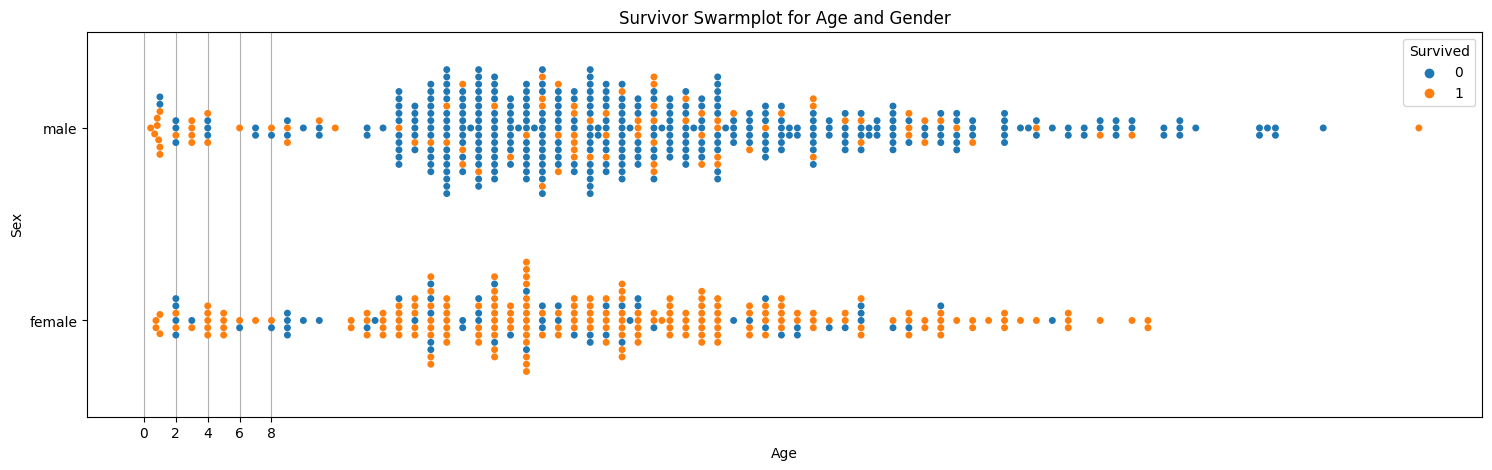

In [31]:
plot_swarm_survivors(train_data, "Sex", "Age", "Survivor Swarmplot for Age and Gender")


### Observation:

As expected age holds valuable information. The swarm plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age. It's also interesting to see that the oldest passenger 80 year old man survived.


## 2.7 Analyze Features Age and Pclass together

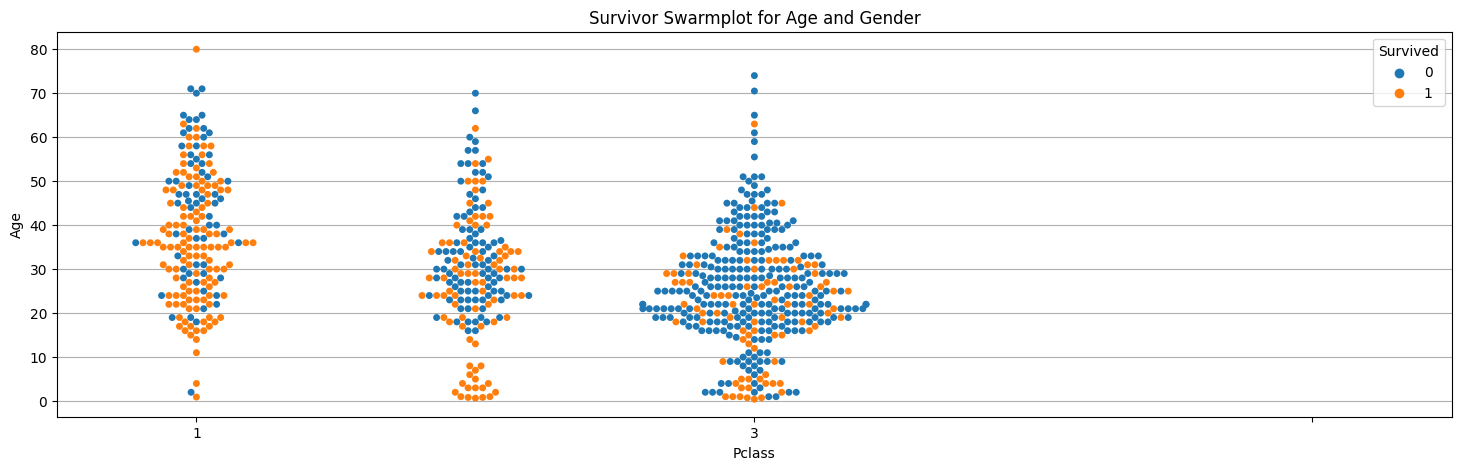

In [32]:
plot_swarm_survivors(train_data, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")


### Observation:

Once more we can see the importance of Pclass when it comes to predicting the likelihood of survival.
One additional piece of information from the plot above is that the first-class did not have a lot of children. Maybe rich people get fewer kids?


## 2.8 Analyze Feature Fare:

In [33]:
 train_data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

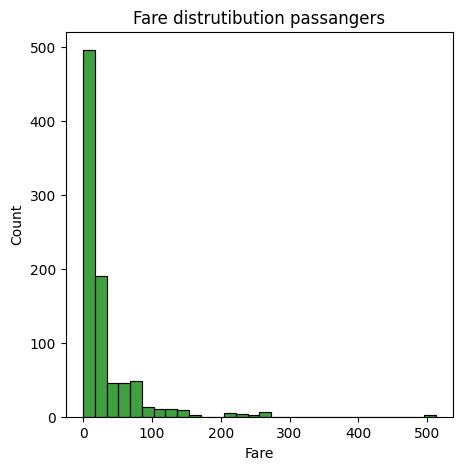

In [34]:
plot_distribution(train_data, "Fare", "Fare distrutibution passangers")

### Observation:

Fare does not follow a normal distribution and has a huge spike at the price range [0-100$].

The distribution is skewed to the left with 75% of the fare paid under 31% and a max paid fare of 512$. Depending on the model that I'm going to use it might make sense to normalize this feature. However, this aspect will be tackled later in the feature engineering section.

To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived. However, due to the large range of fares such as plot would not be useful for inferring useful information.

A more suited visualization would be to combine fares into categories and then plot the categories vs Survived.


In [35]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, errorbar=None, ax=axarr).set_ylabel('Survival rate')


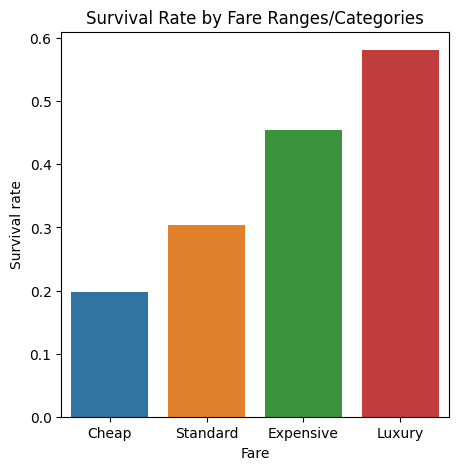

In [36]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(train_data, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

### Observation:

As we can see the likelihood of survival is definitely influenced by the price paid.

*     Cheap (0-25% of max Price): Surival Rate = 0.2 (aprox)
*     Cheap (25%-50% of max Price): Surival Rate = 0.3 (aprox)
*     Cheap (50%-75% of max Price): Surival Rate = 0.45 (aprox)
*     Cheap (75%-100% of max Price): Surival Rate = 0.55 (aprox)

Additionally, we can investigate the relationship between fare, sex and survived to further understand the importance of the feature.


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 63.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


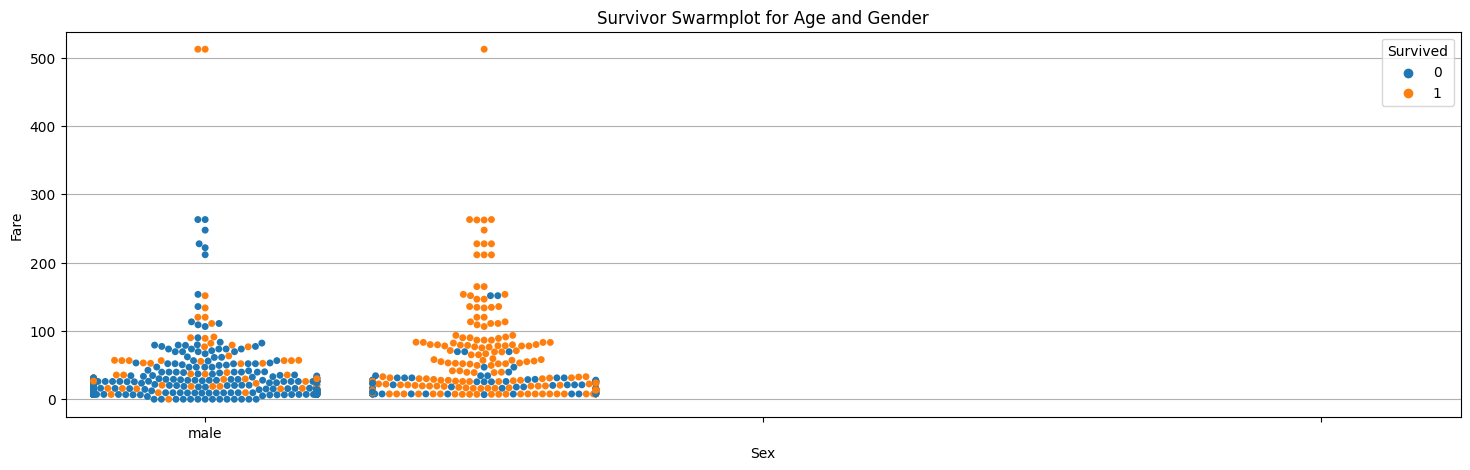

In [37]:
plot_swarm_survivors(train_data, "Fare", "Sex","Survivor Swarmplot for Age and Gender")



Observation:

Here, some important observations can be made:

* Irrespective of gender all passengers with a fare above 500$ survived.
* All male passenger that paid between 200-300 $ died.
* All female passenger that paid between 200-300$ died.

This could be a feature a classifier might pick up.

One thing that caught my attention is that the minimum fare paid was 0.0 $.

This seems highly unlikely. We can investigate who these people were:


In [38]:
train_data.loc[train_data.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [39]:
len(train_data.loc[train_data.Fare==0])

15

### Observation:

15 Passengers paid no fare. As this is nonsensical I decide to replace 0 values with nan and then later to think about how to impute these values.


In [40]:
# Replace Fare == 0 with nan
train_data.loc[train_data['Fare'] == 0, 'Fare'] = np.NaN
test_data.loc[train_data['Fare'] == 0, 'Fare'] = np.NaN



In [41]:
len(train_data.loc[train_data.Fare==0])

0

## 2.9 Analyze Feature Embarked

In [42]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)  

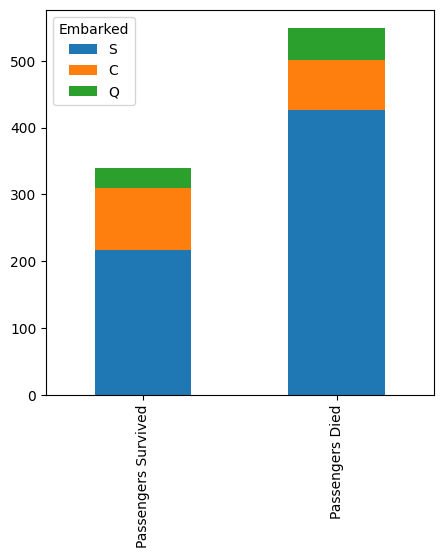

In [43]:
bar_chart_stacked(train_data, 'Embarked') 



In [44]:
train_data['Embarked'].value_counts().to_frame()

,count
Embarked,
S,644
C,168
Q,77


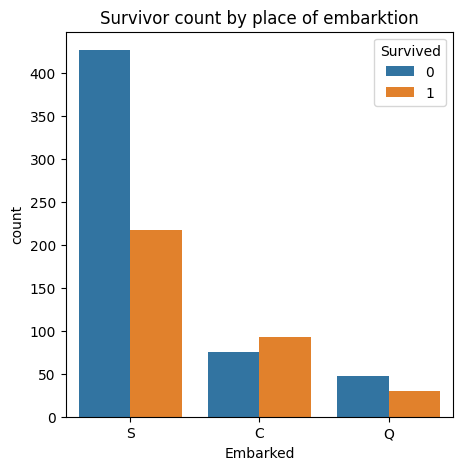

In [45]:
show_compare_countplot(train_data, "Embarked", "Survived", "Survivor count by place of embarktion")

In [46]:
train_data['Embarked'].value_counts().to_frame()

,count
Embarked,
S,644
C,168
Q,77



### Observation:

There are three possible values for the Embarked Feature:

* Southampton, Cherbourg, and Queenstown.

We can see that the majority of passengers embarked from Southampton. However, only 33% survived the sinking of the titanic.

The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg

Using common sense I would not expect that the place of border changes the likelihood of survival.

Why is the likelihood of survival higher at Cherbourg? As we know from above a better class increases the survival rate drastically. One indicator may be the percentage of 1. Class passengers that embarked at Cherbourg:


## 2.10 Analyze Features Embarked & Pclass together


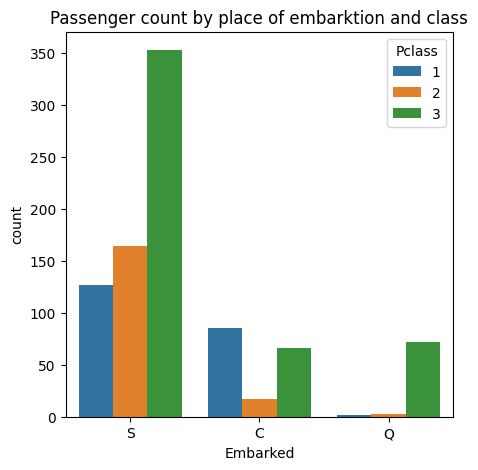

In [47]:
show_compare_countplot(train_data, "Embarked", "Pclass","Passenger count by place of embarktion and class")

In [48]:
train_data.groupby(["Embarked","Pclass"]).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67


### Observation:

The hypothesis seems to be correct.

* The majority embarked at Cherbourg were 1. class passengers.
* The majority embarked at Southampton were 3. class passengers.

However, it does not explain why the survival rate at Queenstown is slightly higher than at Southampton even though the number of 1. class passenger concerning 3. class passengers is higher at Southampton.

One hypothesis is that maybe the ratio between male and female passengers differs:


## 2.11 Analyze Features Embarked & Sex together

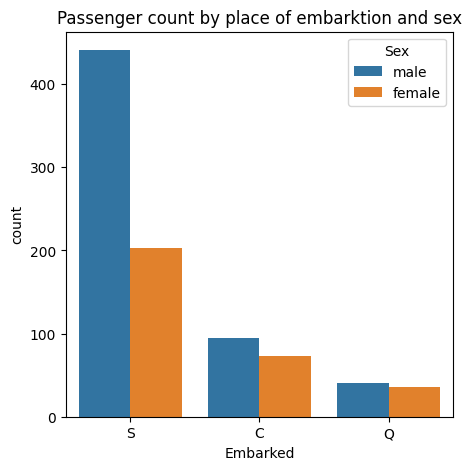

In [49]:
show_compare_countplot(train_data,"Embarked", "Sex","Passenger count by place of embarktion and sex")

### Observation:

As expected twice as many male passengers embarked from Southam were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.


## 2.12 Analyze Feature SibSp:
SibSp is the number of siblings or spouses of a person aboard the Titanic

In [50]:
train_data['SibSp'].value_counts().to_frame()

,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


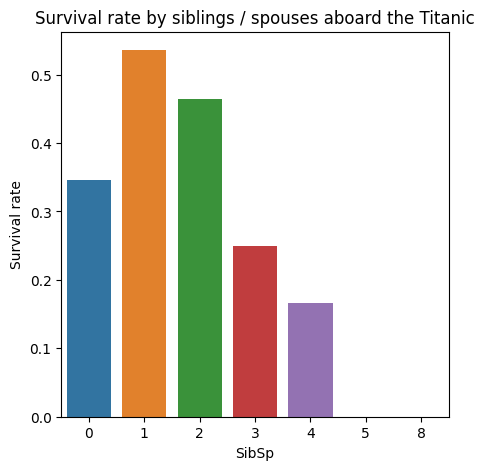

In [51]:
bar_chart_compare(train_data, "SibSp",title= "Survival rate by siblings / spouses aboard the Titanic")

In [52]:
train_data.groupby(['SibSp']).Survived.mean().to_frame()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


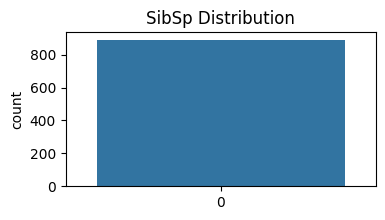

In [53]:
show_countplot(train_data, "SibSp" ,"SibSp Distribution", (4,2))

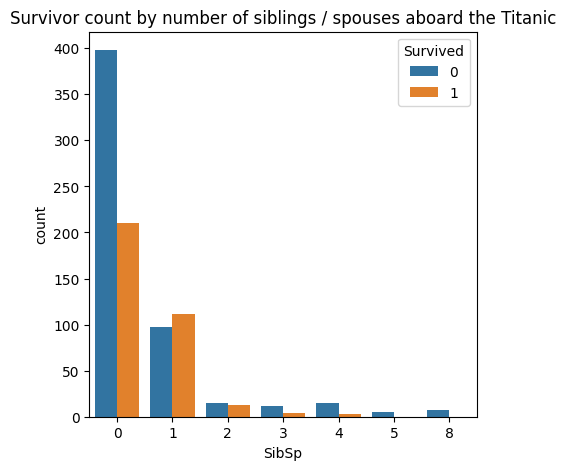

In [54]:
show_compare_countplot(train_data, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

### Observarion:

The majority traveled alone. It seems that the more Sibling a passenger has the less chance of survival there is.


## 2.12 Analyze Feature Parch
Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with.

Here we draw the same conclusions as SibSp; we see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

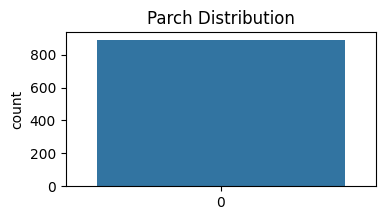

In [55]:
 show_countplot(train_data, "Parch", "Parch Distribution", (4,2))

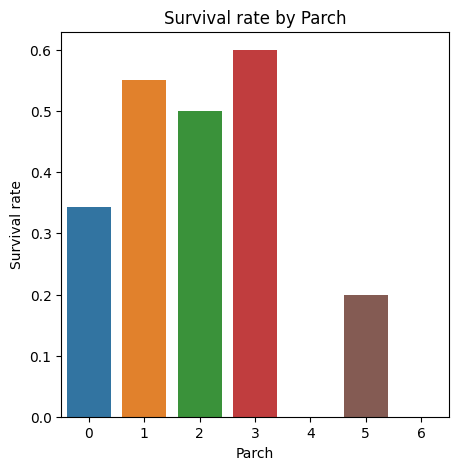

In [56]:
bar_chart_compare(train_data,"Parch", title = "Survival rate by Parch" )

In [57]:
train_data.groupby(['Parch']).Survived.mean().to_frame()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


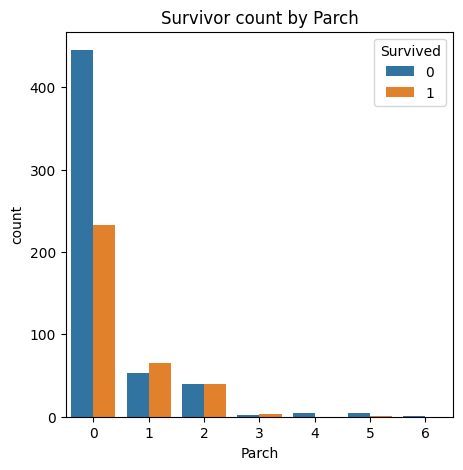

In [58]:
show_compare_countplot(train_data, 'Parch', 'Survived', 'Survivor count by Parch')

### Observation:
Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with. Here we draw the same conclusions as SibSp; we see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

Both features do not seem to be very informative, however, higher abstraction levels trees might pick up certain groups. For faster training, it might be beneficial to combine both features into 1 and create a family size feature.

In [59]:
from sklearn.ensemble import RandomForestClassifier
y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators =100, max_depth =5, random_state=1)
model.fit(X,y)
predictions = model.predict(X_test)
output = pd.DataFrame({"PassengerId": test_data.PassengerId, "Survived": predictions})
print ("You submission was successfully saved")

You submission was successfully saved
